In [50]:
import numpy as np
import pandas as pd
import os
import tifffile
import cv2
from os.path import join, isfile, exists
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import os
from PIL import Image
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import copy
import warnings
import contextlib

In [3]:
def get_condition(title):
    # Load the Excel file into a DataFrame
    df = pd.read_excel('../fig5_tile_conditions.xlsx')

    # Filter the DataFrame based on the given parameters
    filtered_df = df[(df['Experiment'].dt.day == int(title.split('_')[0])) & (df['Tile'] == int(title.split('_')[1]))]

    # Check if there are any matching rows
    if len(filtered_df) > 0:
        # Retrieve the condition from the first matching row
        condition = filtered_df.iloc[0]['Condition']
        return condition
    else:
        return None

In [51]:
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None, timestamp=1):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        label_map 
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            files = [f for f in os.listdir(folder_path) if isfile(join(folder_path, f))]
            label = get_condition(folder)
            # print(folder_path, label)
            for file in files:
                file_path = os.path.join(folder_path, file)
                match = re.search(r'_t(\d+)_c002', file)
                if match:
                    number = int(match.group(1))
                    if number == timestamp:
                        # print(file)
                        if file_path.endswith(".png"):
                            img = Image.open(file_path).convert("RGB")
                            name = file.split("_")[0]
                            label = label_map.get(label, -1)
                            if label != -1:
                                self.images.append(img)
                                self.labels.append(label)
                            # self.labels.append(lable_map[name])
                        elif file_path.endswith(".tif"):
                            try:
                                image_array = tifffile.imread(file_path)
                            except TypeError:
                                pass
                                # print(e)
                            img_rescaled = 255 * (image_array - image_array.min()) / (image_array.max() - image_array.min())
                            img_col = cv2.applyColorMap(img_rescaled.astype(np.uint8), cv2.COLORMAP_DEEPGREEN)
                            img = Image.fromarray(img_col)
                            img = img.convert("RGB")
                            name = file.split("_")[0]
                            label = label_map.get(label, -1)
                            if label != -1:
                                self.images.append(img)
                                self.labels.append(label)
                            break
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label


In [88]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25, debug=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_values = []
    for epoch in range(num_epochs+1):
        if epoch % 5 == 0 and debug:
            print(f'Epoch {epoch}/{num_epochs}')
            
    
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += (preds == labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / len(dataloaders[phase])
            loss_values.append(epoch_loss)
            epoch_acc =  running_corrects / total
            if epoch % 5 == 0 and debug:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')   
                

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if epoch % 5 == 0 and debug:  
            print('-' * 10)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_values

In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def get_metrics(model, test_dataloader):
    true_labels = []
    predicted_labels = []
    accuracy_values = []
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            # true_labels.extend(labels.numpy())
            # predicted_labels.extend(predicted.numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    accuracy = accuracy_score(true_labels, predicted_labels)
    # print(f"accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")
    return accuracy, precision, recall, f1


In [61]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize(input_shape[1:]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Load the dataset
def get_dataloaders(time):
    dataset = MyDataset("D:/Dropbox/CZIConverted", transform=transform, timestamp=time)
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
    # Create data loaders for train and test sets
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    dataloaders = {'train': train_dataloader, 'val': test_dataloader}
    return dataloaders

In [70]:
label_map = {"BMP4" :0, "CHIR": 1, "DS": 2, "DS+CHIR": 3,  "WT": 4}
# Define the input shape of the images
input_shape = (3, 224, 224)
# Define the number of classes
num_classes = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.googlenet(pretrained=True)

In [71]:
# freezed model
for param in model.parameters():
    param.requires_grad = False
# # # Remove the last fully connected layer
model.fc = nn.Identity()
model.fc.requires_grad = True
# Replace the last fully connected layer with a new layer that has `num_classes` output units
model.fc = nn.Linear(1024, num_classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

In [66]:
# unfreezed model
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

In [89]:
import sys
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
original_stderr = sys.stderr
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
sys.stderr = open(os.devnull, 'w')
for timestamp in range(1, 290):
    print("timestamp: ", timestamp)
    dataloaders = get_dataloaders(timestamp)
    model_trained, loss_values = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)
    accuracy, precision, recall, f1 = get_metrics(model_trained, dataloaders['val'])
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
sys.stderr = original_stderr

timestamp:  1
Training complete in 0m 3s
Best val Acc: 0.750000
timestamp:  2
Training complete in 0m 3s
Best val Acc: 0.812500
timestamp:  3
Training complete in 0m 3s
Best val Acc: 0.750000
timestamp:  4
Training complete in 0m 3s
Best val Acc: 0.750000
timestamp:  5
Training complete in 0m 3s
Best val Acc: 0.687500
timestamp:  6
Training complete in 0m 3s
Best val Acc: 0.750000
timestamp:  7
Training complete in 0m 3s
Best val Acc: 0.812500
timestamp:  8
Training complete in 0m 3s
Best val Acc: 0.750000
timestamp:  9
Training complete in 0m 3s
Best val Acc: 0.687500
timestamp:  10
Training complete in 0m 3s
Best val Acc: 0.750000
timestamp:  11
Training complete in 0m 3s
Best val Acc: 0.687500
timestamp:  12
Training complete in 0m 3s
Best val Acc: 0.500000
timestamp:  13
Training complete in 0m 3s
Best val Acc: 0.812500
timestamp:  14
Training complete in 0m 3s
Best val Acc: 0.562500
timestamp:  15
Training complete in 0m 3s
Best val Acc: 0.687500
timestamp:  16
Training complete i

In [69]:
print(accuracy_list)
print(precision_list)
print(recall_list)
print(f1_list)

[0.5625, 0.6875, 0.6875, 0.6875, 0.75, 0.8125, 0.75, 0.75, 0.6875]
[0.6333333333333333, 0.7100000000000001, 0.78, 0.7333333333333333, 0.8300000000000001, 0.7999999999999999, 0.8300000000000001, 0.7766666666666666, 0.72]
[0.6133333333333334, 0.66, 0.72, 0.72, 0.7866666666666666, 0.7999999999999999, 0.7866666666666666, 0.76, 0.6933333333333334]
[0.5442857142857143, 0.6447619047619048, 0.6785714285714286, 0.6714285714285714, 0.7357142857142858, 0.7866666666666665, 0.7557142857142857, 0.7247619047619047, 0.6411111111111111]


In [111]:
def plot_metric(lst, title, line=''):
    # x_values = [i + 1 for i in range(len(lst))]
    # x_values = [i * 50 for i in range(1, len(accuracy_list)//50 + 1)]
    # Plot the accuracy values
    x_values = [i + 1 for i in range(len(lst)) if i % 10 == 0]
    lst = [lst[i] for i in range(len(lst)) if i % 10 == 0]
    
    
    plt.plot(x_values, lst, marker='o', linestyle=line)
    plt.ylim(0, 1)
    # Set the x-axis label and title
    plt.xlabel('Timestamp')
    plt.ylabel(title)
    plt.title('InceptionV1')
    # Define the desired tick locations and labels
    xtick_locations = np.arange(0, len(accuracy_list), 50)
    xtick_labels = [str(x) for x in xtick_locations]

    # Set the x-axis tick locations and labels
    plt.xticks(xtick_locations, xtick_labels)
    # plt.xticks(range(1, len(accuracy_list) + 1))
    # Display the plot
    plt.show()

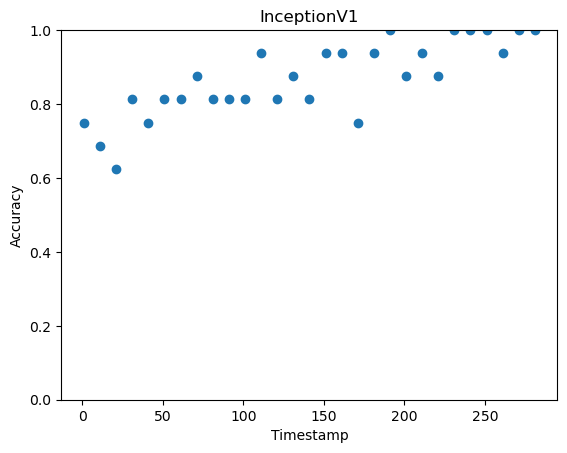

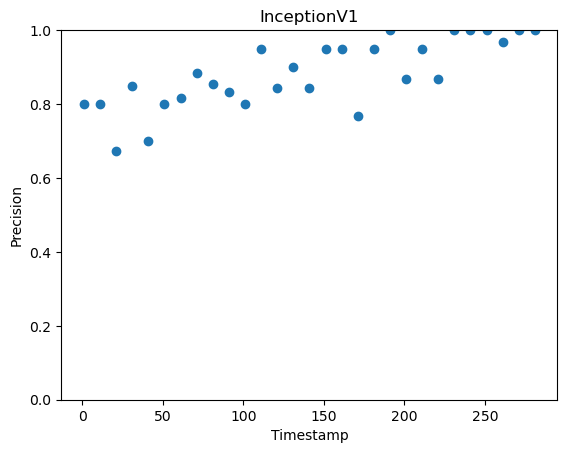

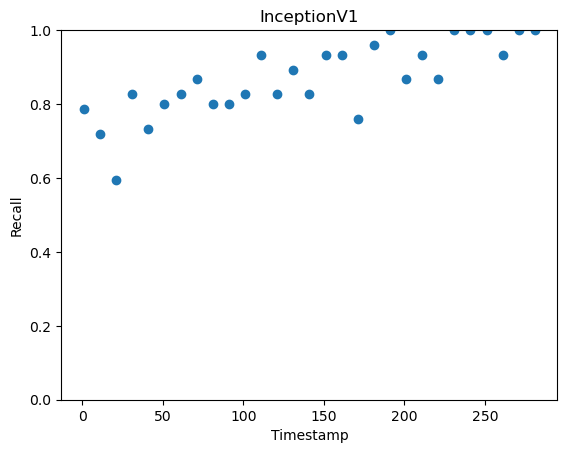

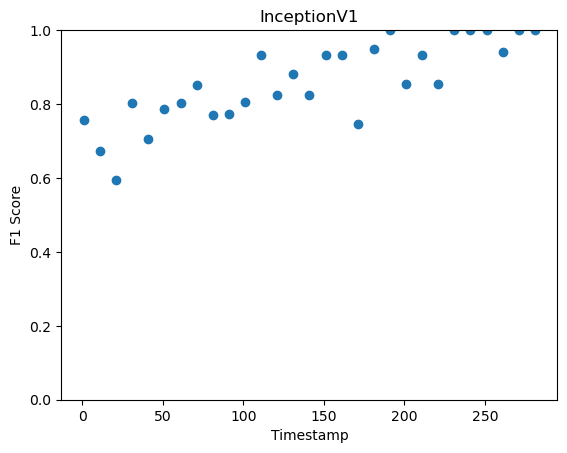

In [113]:
# print(accuracy_list)
# print(precision_list)
# print(recall_list)
# print(f1_list)
plot_metric(accuracy_list, 'Accuracy')
plot_metric(precision_list, 'Precision')
plot_metric(recall_list, 'Recall')
plot_metric(f1_list, 'F1 Score')


In [86]:
import sys
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
original_stderr = sys.stderr
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
sys.stderr = open(os.devnull, 'w')
for timestamp in range(1, 290):
    print("timestamp: ", timestamp)
    dataloaders = get_dataloaders(timestamp)
    model_trained, loss_values = train_model(model, criterion, optimizer, dataloaders, num_epochs=20)
    accuracy, precision, recall, f1 = get_metrics(model_trained, dataloaders['val'])
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
sys.stderr = original_stderr

timestamp:  1
Epoch 0/20
train Loss: 0.5147 Acc: 0.8710
val Loss: 0.7450 Acc: 0.6250
----------
Epoch 5/20
train Loss: 0.5776 Acc: 0.8387
val Loss: 0.7876 Acc: 0.6875
----------
Epoch 10/20
train Loss: 0.3978 Acc: 0.9355
val Loss: 0.7299 Acc: 0.7500
----------
Epoch 15/20
train Loss: 0.4071 Acc: 0.9032
val Loss: 0.7608 Acc: 0.6875
----------
Epoch 20/20
train Loss: 0.3587 Acc: 0.9355
val Loss: 0.7547 Acc: 0.6875
----------
Training complete in 0m 5s
Best val Acc: 0.750000
timestamp:  2
Epoch 0/20
train Loss: 0.4280 Acc: 0.9516
val Loss: 0.7332 Acc: 0.8125
----------
Epoch 5/20
train Loss: 0.4614 Acc: 0.9032
val Loss: 0.7448 Acc: 0.7500
----------
Epoch 10/20
train Loss: 0.3478 Acc: 0.9839
val Loss: 0.6994 Acc: 0.7500
----------
Epoch 15/20
train Loss: 0.3808 Acc: 0.9194
val Loss: 0.6835 Acc: 0.7500
----------
Epoch 20/20
train Loss: 0.2505 Acc: 0.9839
val Loss: 0.6961 Acc: 0.8125
----------
Training complete in 0m 5s
Best val Acc: 0.812500
timestamp:  3
Epoch 0/20
train Loss: 0.6338 Ac

In [20]:
# Train the model
# model = reset_model_no_freeze()
num_epochs = 30
loss_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_dataloader)
    loss_values.append(average_loss)
    print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {average_loss:.3f}")      

[Epoch 1, Batch 8] Loss: 1.696
[Epoch 2, Batch 8] Loss: 1.687
[Epoch 3, Batch 8] Loss: 1.647
[Epoch 4, Batch 8] Loss: 1.682
[Epoch 5, Batch 8] Loss: 1.670
[Epoch 6, Batch 8] Loss: 1.667
[Epoch 7, Batch 8] Loss: 1.681
[Epoch 8, Batch 8] Loss: 1.662
[Epoch 9, Batch 8] Loss: 1.665
[Epoch 10, Batch 8] Loss: 1.682
[Epoch 11, Batch 8] Loss: 1.667
[Epoch 12, Batch 8] Loss: 1.643
[Epoch 13, Batch 8] Loss: 1.674
[Epoch 14, Batch 8] Loss: 1.653
[Epoch 15, Batch 8] Loss: 1.629
[Epoch 16, Batch 8] Loss: 1.676
[Epoch 17, Batch 8] Loss: 1.681
[Epoch 18, Batch 8] Loss: 1.656
[Epoch 19, Batch 8] Loss: 1.672
[Epoch 20, Batch 8] Loss: 1.670
[Epoch 21, Batch 8] Loss: 1.671
[Epoch 22, Batch 8] Loss: 1.671
[Epoch 23, Batch 8] Loss: 1.649
[Epoch 24, Batch 8] Loss: 1.628
[Epoch 25, Batch 8] Loss: 1.672
[Epoch 26, Batch 8] Loss: 1.658
[Epoch 27, Batch 8] Loss: 1.633
[Epoch 28, Batch 8] Loss: 1.678
[Epoch 29, Batch 8] Loss: 1.697
[Epoch 30, Batch 8] Loss: 1.664


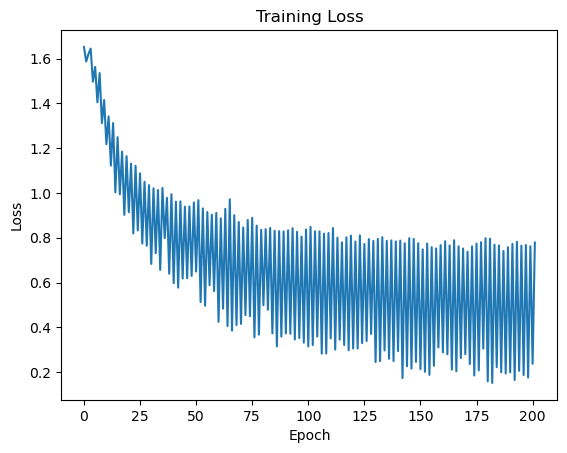

In [259]:
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_labels = []
predicted_labels = []
accuracy_values = []
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"tranfer no freezing 20 epochs")
print(f"accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

tranfer no freezing 20 epochs
accuracy: 0.625
Precision: 0.6833333333333333
Recall: 0.6533333333333333
F1 Score: 0.6142857142857142
